In [1]:
%pip install pandas torch 
%pip install setfit transformers sentence-transformers
%pip install --upgrade transformers
%pip install --upgrade sentence-transformers
%pip install tf-keras
%pip install sentencepiece matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
## Read the dataframe

import pandas as pd

# Load your DataFrame
Master_all_Cleaned = pd.read_csv('../clean_data/Master_all_Cleaned.csv')

In [5]:
Master_all_Cleaned = Master_all_Cleaned.drop_duplicates()
Master_all_Cleaned.head()

,Mentor ID,Mentee ID,Relationship ID,Response Datetime,Response,Mentor,Category
0,1047517758,1047538818,40134,2021-09-14 14:46:00,Hi Allan! My name is Lillie and I am a fourth ...,Mentor,"Posts in {""en""=>""Program\nInstructions""}"
1,1047512489,1047538891,40137,2021-09-14 16:05:00,"Hello, I'm Eden, I use he/they pronouns and I ...",Mentee,"Posts in {""en""=>""Program\nInstructions""}"
2,1047516311,1047538822,40133,2021-09-14 16:07:00,Hi,Mentee,"Posts in {""en""=>""Program\nInstructions""}"
3,1047516309,1047540777,40136,2021-09-14 16:07:00,Hi Colleen! My name is Khalifa and I'm going t...,Mentor,"Posts in {""en""=>""Program\nInstructions""}"
4,1047499271,1047538812,40139,2021-09-14 16:16:00,Hi,Mentee,"Posts in {""en""=>""Program\nInstructions""}"


In [6]:
## Initialize a classifier
from transformers import pipeline
# Initializing the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", 
                      model="facebook/bart-large-mnli")
# Defining mood categories
mood_categories = ["happiness", "excitement", "gratitude", "contempt",
                    "sadness",  "nervousness", "stress", "boredom"]

/zfs/users/asda1/asda1/miniconda3/envs/env-dssg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-08 07:58:16.326875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 07:58:19.946537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/zfs/users/asda1/asda1/miniconda3/envs/env-dssg/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will

In [36]:
successful_pairs = Master_all_Cleaned[
    ((Master_all_Cleaned['Mentor ID'] == 1047549501) & (Master_all_Cleaned['Mentee ID'] == 1047627563)) |
    ((Master_all_Cleaned['Mentor ID'] == 1047514156) & (Master_all_Cleaned['Mentee ID'] == 1047627558)) |
    ((Master_all_Cleaned['Mentor ID'] == 1047516499) & (Master_all_Cleaned['Mentee ID'] == 1047540775)) |
    ((Master_all_Cleaned['Mentor ID'] == 1047581869) & (Master_all_Cleaned['Mentee ID'] == 1047592252)) |
    ((Master_all_Cleaned['Mentor ID'] == 1047567623) & (Master_all_Cleaned['Mentee ID'] == 1047582366)) |
    ((Master_all_Cleaned['Mentor ID'] == 1047549915) & (Master_all_Cleaned['Mentee ID'] == 1047594026)) |
    ((Master_all_Cleaned['Mentor ID'] == 1047590948) & (Master_all_Cleaned['Mentee ID'] == 1047592259)) |
    ((Master_all_Cleaned['Mentor ID'] == 1047546975) & (Master_all_Cleaned['Mentee ID'] == 1047541030))

]

# Extract text and timestamp
#mentee_sample_data = Master_all_Cleaned[Master_all_Cleaned['Mentor'] == 'Mentee'].head(500)
#mentee_sample_data = Master_all_Cleaned[Master_all_Cleaned['Mentor'] == 'Mentee']
mentee_sample_data = successful_pairs

mentee_sample_data_list = mentee_sample_data['Response'].tolist()
mentee_timestamps_list = mentee_sample_data['Response Datetime'].tolist()

# Convert all entries to strings and filter out text segments with fewer than 5 words
mentee_filtered_data = [
    (str(text), timestamp) for text, timestamp in zip(mentee_sample_data_list, mentee_timestamps_list)
    if len(str(text).split()) > 5
]

# Unzip the filtered data into separate lists
if mentee_filtered_data:  # Check if the list is not empty
    mentee_filtered_texts_list, mentee_filtered_timestamps_list = zip(*mentee_filtered_data)
else:
    mentee_filtered_texts_list, mentee_filtered_timestamps_list = [], []

In [37]:
import pandas as pd

# Define a threshold for considering a label as predicted
threshold = 0.0

predicted_labels = []
predicted_scores = []
results = []

for text, timestamp in zip(mentee_filtered_texts_list, mentee_filtered_timestamps_list):
    result = classifier(text, candidate_labels=mood_categories)
    results.append((result, timestamp))
    
    # Collect all labels and scores above the threshold
    labels_above_threshold = [(label, round(score, 6)) for label, score in zip(result['labels'], result['scores']) if score >= threshold]
    predicted_labels.append([label for label, score in labels_above_threshold])
    predicted_scores.append([score for label, score in labels_above_threshold])


# Create a DataFrame to store the results
data = {
    'Timestamp': mentee_filtered_timestamps_list,
    'Response': mentee_filtered_texts_list,
    'Predicted Labels': predicted_labels,
    'Scores': predicted_scores
}

predicted_df = pd.DataFrame(data)


#predicted_df

# # Merge the predicted DataFrame with the original DataFrame on the 'Response' column
final_df = pd.merge(Master_all_Cleaned, predicted_df, on='Response', how='inner')


pd.set_option('display.max_colwidth', None)

In [38]:
pd.set_option('display.max_colwidth', None)
final_df.head(1)

,Mentor ID,Mentee ID,Relationship ID,Response Datetime,Response,Mentor,Category,Timestamp,Predicted Labels,Scores
0,1047546975,1047541030,42216,2021-10-01 18:52:00,"Why hello there! To be perfectly frank, I'm here because it's a school\nproject, but don't let that deter you. Hopefully this turns into something cool, and if not, then\nits still counted as school work (awesome). Oop my name is Evan by the way, probably should have\nlead with that, but you probably know that anyways what with the email system. Anywho, I suppose we\nhave to do some convo starters. It's saying that I get to choose, so here we go. Food for thought\nsounds good. I'm actually just about to start making some kickass brownies right now, but I figured\nhomework would probably be the best way to start things out. I'm not actually a fan of chocolate,\nbut I figured I'd give the brownies a go. Fingers crossed. For my favorite song/artist I would have\nto go with vivaldi's ""les quatres saisons: L'hiver."" Vivaldi is an amazing composer. Well that was a\nsuper basic convo starter, but it'll do. Hope you enjoy brownies, cause I'll probably end up sending\nyou some pics. Have a good weekend, and bye. I really hope this isn't going to be marked. ... Bye\nfor real.",Mentee,"Posts in {""en""=>""Program\nInstructions""}",2021-10-01 18:52:00,"[excitement, contempt, nervousness, stress, sadness, happiness, gratitude, boredom]","[0.252003, 0.155751, 0.140398, 0.1255, 0.09421, 0.089727, 0.084718, 0.057692]"


In [39]:
### Get the emotions table without the texts 

mentees_emotions_df = final_df[["Mentee ID","Relationship ID", "Response Datetime", "Predicted Labels", "Scores"]]
mentees_emotions_df = pd.DataFrame(mentees_emotions_df)
mentees_emotions_df

,Mentee ID,Relationship ID,Response Datetime,Predicted Labels,Scores
0,1047541030,42216,2021-10-01 18:52:00,"[excitement, contempt, nervousness, stress, sadness, happiness, gratitude, boredom]","[0.252003, 0.155751, 0.140398, 0.1255, 0.09421, 0.089727, 0.084718, 0.057692]"
1,1047541030,42216,2021-10-01 19:37:00,"[nervousness, excitement, happiness, contempt, gratitude, stress, boredom, sadness]","[0.472072, 0.236148, 0.060974, 0.056173, 0.053126, 0.043418, 0.043288, 0.034801]"
2,1047541030,42216,2021-10-01 21:49:00,"[contempt, nervousness, stress, excitement, sadness, boredom, happiness, gratitude]","[0.275156, 0.149929, 0.122871, 0.114551, 0.107371, 0.086815, 0.074628, 0.068678]"
3,1047541030,42216,2021-10-01 23:35:00,"[excitement, gratitude, contempt, nervousness, happiness, stress, sadness, boredom]","[0.365164, 0.148328, 0.140013, 0.089935, 0.089797, 0.064718, 0.054848, 0.047198]"
4,1047541030,42216,2021-10-02 00:10:00,"[contempt, excitement, happiness, sadness, stress, gratitude, nervousness, boredom]","[0.189262, 0.184432, 0.134758, 0.123044, 0.115493, 0.101858, 0.096767, 0.054385]"
...,...,...,...,...,...
309,1047627558,67332,2024-02-06 19:33:00,"[excitement, happiness, gratitude, contempt, stress, nervousness, sadness, boredom]","[0.268488, 0.179331, 0.154005, 0.138723, 0.097935, 0.094982, 0.049741, 0.016795]"
310,1047627558,67332,2024-02-22 02:18:00,"[happiness, excitement, gratitude, stress, nervousness, contempt, boredom, sadness]","[0.70559, 0.122497, 0.070901, 0.036029, 0.029406, 0.019996, 0.012796, 0.002785]"
311,1047627558,67332,2024-02-22 17:10:00,"[gratitude, excitement, nervousness, stress, happiness, contempt, sadness, boredom]","[0.394502, 0.171803, 0.141293, 0.096058, 0.085866, 0.0817, 0.017789, 0.010988]"
312,1047627558,67332,2024-02-26 11:25:00,"[stress, nervousness, excitement, contempt, gratitude, happiness, sadness, boredom]","[0.187494, 0.161366, 0.143059, 0.140243, 0.123202, 0.091136, 0.086958, 0.066542]"


In [40]:
## TODO TODO TODO TODO TODO TODO TODO TODO TODO ADD THIS TO THE WEBSITE TODO TODO TODO  TODO TODO  TODO TODO TODO TODO TODO TODO TODO


import pandas as pd

# Sample data frame (assuming it's already loaded)
# Convert Response Datetime to datetime format
mentees_emotions_df["Response Datetime"] = pd.to_datetime(mentees_emotions_df["Response Datetime"])

# Extract month and year from Response Datetime
mentees_emotions_df["Month"] = mentees_emotions_df["Response Datetime"].dt.month
mentees_emotions_df["Year"] = mentees_emotions_df["Response Datetime"].dt.year

# Function to calculate mean of lists of scores
def mean_of_lists(series):
    return list(pd.DataFrame(series.tolist()).mean())

# Group by Mentee ID, Relationship ID, Month, and Year and calculate the mean of Scores
grouped_df = mentees_emotions_df.groupby(["Mentee ID", "Relationship ID", "Month", "Year"]).agg({
    "Scores": mean_of_lists
}).reset_index()

# Combine the predicted labels by taking the unique labels
grouped_df["Predicted Labels"] = mentees_emotions_df.groupby(["Mentee ID", "Relationship ID", "Month", "Year"])["Predicted Labels"].apply(lambda x: list(pd.Series([label for sublist in x for label in sublist]).unique())).reset_index(drop=True)

# Sort the DataFrame by Year and Month in ascending order
grouped_df = grouped_df.sort_values(by=['Year', 'Month', 'Mentee ID', 'Relationship ID'])

# Display the new DataFrame
grouped_df


,Mentee ID,Relationship ID,Month,Year,Scores,Predicted Labels
3,1047541030,42216,10,2021,"[0.31026269230769227, 0.1792888461538461, 0.1282613076923077, 0.10326519230769231, 0.0917046923076923, 0.07805830769230769, 0.06444407692307692, 0.044714769230769225]","[excitement, contempt, nervousness, stress, sadness, happiness, gratitude, boredom]"
4,1047541030,42216,11,2021,"[0.338908, 0.2080054, 0.12857659999999999, 0.0935001, 0.080806, 0.0633929, 0.0513518, 0.0354594]","[happiness, excitement, gratitude, contempt, stress, nervousness, sadness, boredom]"
5,1047541030,42216,12,2021,"[0.44459, 0.335787, 0.075296, 0.046561, 0.03435866666666667, 0.028425000000000002, 0.022645333333333333, 0.012336666666666668]","[sadness, gratitude, happiness, nervousness, excitement, contempt, stress, boredom]"
0,1047540775,40437,3,2022,"[0.29921, 0.194217, 0.137065, 0.1220075, 0.09389349999999999, 0.073171, 0.052542, 0.027894000000000002]","[nervousness, gratitude, stress, happiness, excitement, sadness, contempt, boredom]"
1,1047540775,40437,4,2022,"[0.267746, 0.21692766666666666, 0.14235366666666668, 0.12802733333333333, 0.093532, 0.05873433333333333, 0.04919433333333334, 0.043484]","[gratitude, nervousness, excitement, happiness, stress, contempt, sadness, boredom]"
2,1047540775,40437,5,2022,"[0.382128, 0.21071566666666666, 0.10446933333333334, 0.09374500000000001, 0.07560166666666666, 0.06145, 0.045320000000000006, 0.02656966666666667]","[excitement, contempt, gratitude, stress, nervousness, happiness, sadness, boredom]"
8,1047582366,54540,9,2022,"[0.308138, 0.216553, 0.137939, 0.11341725, 0.07245875, 0.05956625, 0.050005, 0.041923749999999996]","[excitement, contempt, nervousness, gratitude, stress, happiness, boredom, sadness]"
9,1047582366,54540,10,2022,"[0.2795925, 0.2040569, 0.15070730000000002, 0.1106568, 0.0893492, 0.0685984, 0.0534771, 0.0435616]","[nervousness, excitement, stress, contempt, gratitude, happiness, sadness, boredom]"
10,1047582366,54540,11,2022,"[0.39984349999999996, 0.1436022857142857, 0.12185692857142857, 0.10134050000000001, 0.08304264285714287, 0.06669128571428572, 0.047496642857142855, 0.036126285714285715]","[stress, contempt, nervousness, excitement, sadness, gratitude, happiness, boredom]"
11,1047582366,54540,12,2022,"[0.2359871111111111, 0.1731642222222222, 0.1528531111111111, 0.1215858888888889, 0.10244588888888889, 0.08262222222222222, 0.07232755555555555, 0.059013333333333334]","[contempt, stress, excitement, sadness, happiness, gratitude, nervousness, boredom]"


In [41]:
# # Display the new DataFrame
# grouped_df_ = grouped_df[grouped_df["Mentee ID"] == 1047541031]
# grouped_df_

,Mentee ID,Relationship ID,Month,Year,Scores,Predicted Labels


In [53]:
df = pd.DataFrame(grouped_df)
df.head(50)

,Mentee ID,Relationship ID,Month,Year,Scores,Predicted Labels
3,1047541030,42216,10,2021,"[0.31026269230769227, 0.1792888461538461, 0.1282613076923077, 0.10326519230769231, 0.0917046923076923, 0.07805830769230769, 0.06444407692307692, 0.044714769230769225]","[excitement, contempt, nervousness, stress, sadness, happiness, gratitude, boredom]"
4,1047541030,42216,11,2021,"[0.338908, 0.2080054, 0.12857659999999999, 0.0935001, 0.080806, 0.0633929, 0.0513518, 0.0354594]","[happiness, excitement, gratitude, contempt, stress, nervousness, sadness, boredom]"
5,1047541030,42216,12,2021,"[0.44459, 0.335787, 0.075296, 0.046561, 0.03435866666666667, 0.028425000000000002, 0.022645333333333333, 0.012336666666666668]","[sadness, gratitude, happiness, nervousness, excitement, contempt, stress, boredom]"
0,1047540775,40437,3,2022,"[0.29921, 0.194217, 0.137065, 0.1220075, 0.09389349999999999, 0.073171, 0.052542, 0.027894000000000002]","[nervousness, gratitude, stress, happiness, excitement, sadness, contempt, boredom]"
1,1047540775,40437,4,2022,"[0.267746, 0.21692766666666666, 0.14235366666666668, 0.12802733333333333, 0.093532, 0.05873433333333333, 0.04919433333333334, 0.043484]","[gratitude, nervousness, excitement, happiness, stress, contempt, sadness, boredom]"
2,1047540775,40437,5,2022,"[0.382128, 0.21071566666666666, 0.10446933333333334, 0.09374500000000001, 0.07560166666666666, 0.06145, 0.045320000000000006, 0.02656966666666667]","[excitement, contempt, gratitude, stress, nervousness, happiness, sadness, boredom]"
8,1047582366,54540,9,2022,"[0.308138, 0.216553, 0.137939, 0.11341725, 0.07245875, 0.05956625, 0.050005, 0.041923749999999996]","[excitement, contempt, nervousness, gratitude, stress, happiness, boredom, sadness]"
9,1047582366,54540,10,2022,"[0.2795925, 0.2040569, 0.15070730000000002, 0.1106568, 0.0893492, 0.0685984, 0.0534771, 0.0435616]","[nervousness, excitement, stress, contempt, gratitude, happiness, sadness, boredom]"
10,1047582366,54540,11,2022,"[0.39984349999999996, 0.1436022857142857, 0.12185692857142857, 0.10134050000000001, 0.08304264285714287, 0.06669128571428572, 0.047496642857142855, 0.036126285714285715]","[stress, contempt, nervousness, excitement, sadness, gratitude, happiness, boredom]"
11,1047582366,54540,12,2022,"[0.2359871111111111, 0.1731642222222222, 0.1528531111111111, 0.1215858888888889, 0.10244588888888889, 0.08262222222222222, 0.07232755555555555, 0.059013333333333334]","[contempt, stress, excitement, sadness, happiness, gratitude, nervousness, boredom]"


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Create DataFrame
df = pd.DataFrame(grouped_df)

# Convert month and year to a datetime object
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# Function to plot data for a given Mentee ID
def plot_mentee_data(df, mentee_id):
    mentee_data = df[df['Mentee ID'] == mentee_id]
    
    # Create a plot
    plt.figure(figsize=(12, 8))

    # Extract unique predicted labels
    unique_labels = list({label for labels in mentee_data['Predicted Labels'] for label in labels})
    color_map = plt.get_cmap('tab10')
    
    for label in unique_labels:
        scores_over_time = []
        dates = []
        for _, row in mentee_data.iterrows():
            if label in row['Predicted Labels']:
                idx = row['Predicted Labels'].index(label)
                scores_over_time.append(row['Scores'][idx])
                dates.append(row['Date'])
            else:
                scores_over_time.append(0)
                dates.append(row['Date'])
        
        plt.plot(dates, scores_over_time, label=label, color=color_map(unique_labels.index(label)))

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Scores')
    plt.title(f'Scores of Predicted Labels over Time for Mentee ID {mentee_id}')
    plt.legend()
    plt.grid(True)
    plt.show()

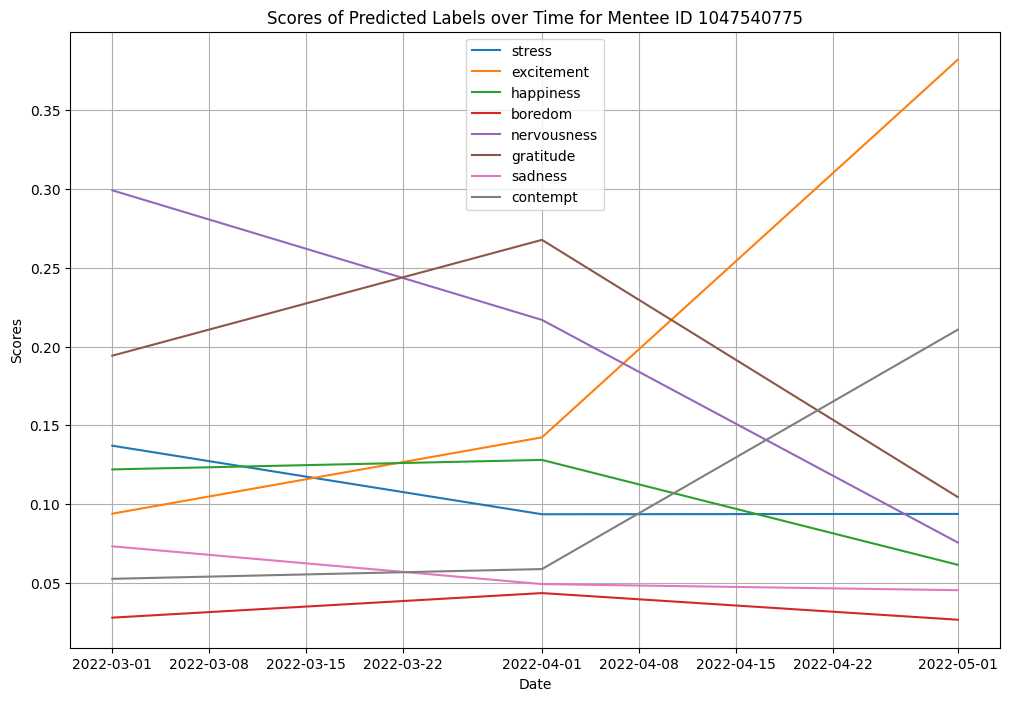

In [57]:
### plot here 


# Call the function with the desired Mentee ID
mentee_id_to_plot = 1047540775  # Change this to the Mentee ID you want to plot
plot_mentee_data(df, mentee_id_to_plot)

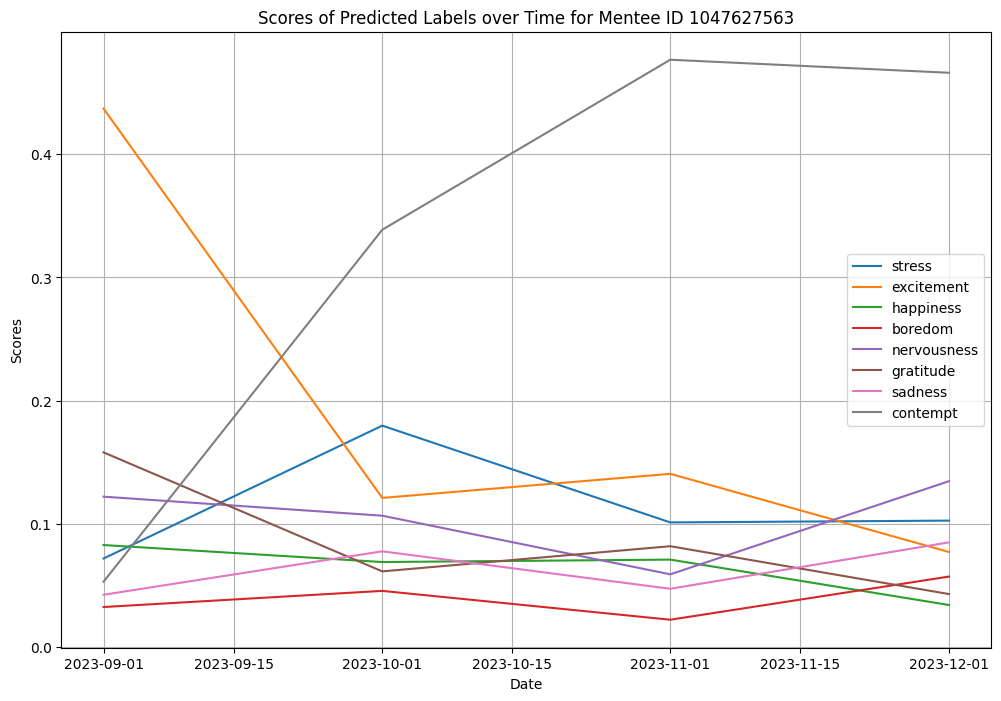

In [59]:
# Call the function with the desired Mentee ID
mentee_id_to_plot = 1047627563  # Change this to the Mentee ID you want to plot
plot_mentee_data(df, mentee_id_to_plot)